# Module 2: Probability Distributions & Inference

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
np.random.seed(42)  # for reproducibility

# nice plots
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 12

---
# Activity 1: Empirical Verification of the Central Limit Theorem

## Background

The **Central Limit Theorem (CLT)** is one of the most important results in statistics. It states that if we have $N$ independent random variables $x_1, x_2, \ldots, x_N$, each with mean $\mu$ and variance $\sigma^2$, then the distribution of the sample mean:

$$\bar{x} = \frac{1}{N} \sum_{i=1}^{N} x_i$$

approaches a Gaussian distribution as $N \to \infty$, with:
- Mean: $\mu_{\bar{x}} = \mu$
- Variance: $\sigma_{\bar{x}}^2 = \frac{\sigma^2}{N}$

The remarkable thing is that this holds **regardless of the original distribution** of the $x_i$'s (as long as they have finite mean and variance).

For a uniform distribution on $[0,1]$:
- $\mu = 0.5$
- $\sigma^2 = \frac{1}{12}$

So for the mean of $N$ uniform variables, we expect:
- $\mu_{\bar{x}} = 0.5$
- $\sigma_{\bar{x}} = \frac{1}{\sqrt{12N}}$

In [24]:
# Generate samples and compute means for different N
n_experiments = 10000  # number of times we compute the mean

def compute_means(N, n_experiments):
    """Generate n_experiments means, each from N uniform[0,1] samples."""
    samples = np.random.uniform(0, 1, size=(n_experiments, N))
    return np.mean(samples, axis=1)

# Compute for N = 1, 2, 10
means_N1 = compute_means(1, n_experiments)
means_N2 = compute_means(2, n_experiments)
means_N10 = compute_means(10, n_experiments)

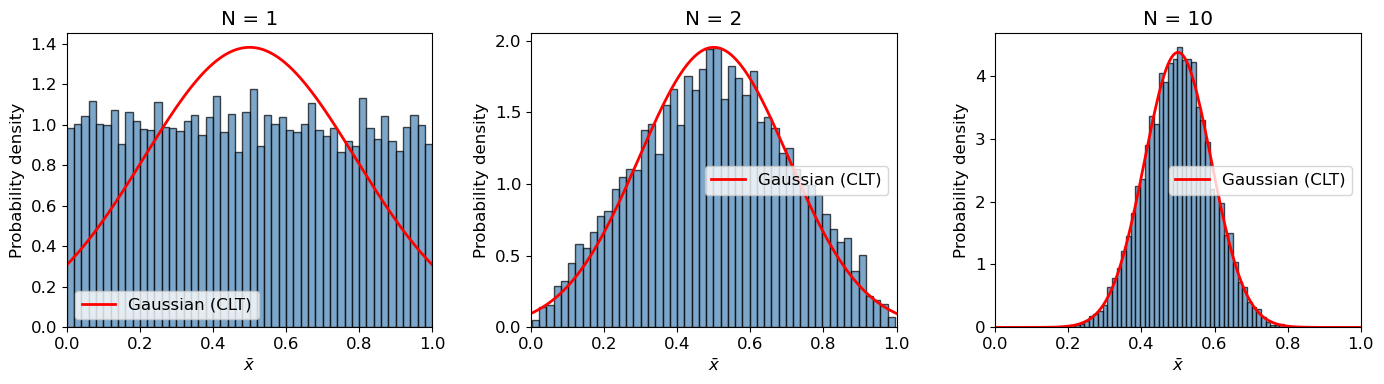

In [25]:
# Plot the distributions
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, means, N in zip(axes, [means_N1, means_N2, means_N10], [1, 2, 10]):
    # histogram
    ax.hist(means, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')
    
    # theoretical Gaussian from CLT
    mu_theory = 0.5
    sigma_theory = 1 / np.sqrt(12 * N)
    x = np.linspace(0, 1, 200)
    gaussian = stats.norm.pdf(x, mu_theory, sigma_theory)
    ax.plot(x, gaussian, 'r-', lw=2, label=f'Gaussian (CLT)')
    
    ax.set_xlabel(r'$\bar{x}$')
    ax.set_ylabel('Probability density')
    ax.set_title(f'N = {N}')
    ax.legend()
    ax.set_xlim(0, 1)

plt.tight_layout()
plt.savefig('activity1_clt.png', dpi=150)
plt.show()

In [26]:
# Fit Gaussian to N=10 case
def gaussian(x, mu, sigma, A):
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2)

# make histogram data for fitting
counts, bin_edges = np.histogram(means_N10, bins=50, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# fit
popt, pcov = curve_fit(gaussian, bin_centers, counts, p0=[0.5, 0.1, 4])
mu_fit, sigma_fit, A_fit = popt

print("=== Gaussian Fit for N=10 ===")
print(f"Fitted mean:     μ = {mu_fit:.4f}  (theory: 0.5)")
print(f"Fitted sigma:    σ = {sigma_fit:.4f}  (theory: {1/np.sqrt(120):.4f})")
print(f"\nSample mean:     {np.mean(means_N10):.4f}")
print(f"Sample std:      {np.std(means_N10):.4f}")

=== Gaussian Fit for N=10 ===
Fitted mean:     μ = 0.4993  (theory: 0.5)
Fitted sigma:    σ = 0.0917  (theory: 0.0913)

Sample mean:     0.4992
Sample std:      0.0911


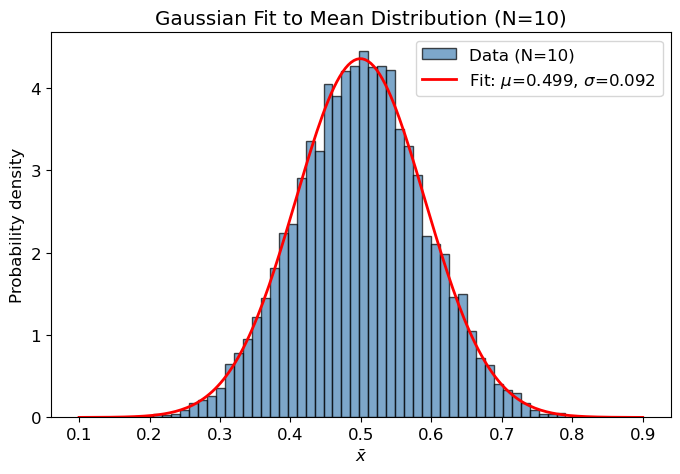

In [27]:
# Plot the fit
plt.figure(figsize=(8, 5))
plt.hist(means_N10, bins=50, density=True, alpha=0.7, color='steelblue', 
         edgecolor='black', label='Data (N=10)')

x = np.linspace(0.1, 0.9, 200)
plt.plot(x, gaussian(x, *popt), 'r-', lw=2, 
         label=f'Fit: $\\mu$={mu_fit:.3f}, $\\sigma$={sigma_fit:.3f}')

plt.xlabel(r'$\bar{x}$')
plt.ylabel('Probability density')
plt.title('Gaussian Fit to Mean Distribution (N=10)')
plt.legend()
plt.savefig('activity1_fit.png', dpi=150)
plt.show()

## Discussion: When is the Gaussian PDF Appropriate?

The CLT tells us that Gaussian distributions show up whenever we're looking at sums or averages of many independent random contributions. This is why Gaussians are everywhere in physics:

1. **Measurement errors**: When we measure something, there are usually many small independent sources of error (thermal noise, electronic noise, mechanical vibrations, etc.). The total error is the sum of these, so by CLT it's approximately Gaussian.

2. **Thermal velocities**: The Maxwell-Boltzmann distribution for particle velocities comes from molecules having many random collisions. Each velocity component is Gaussian.

3. **Diffusion**: Random walk processes (like Brownian motion) lead to Gaussian distributions for particle positions after many steps.

4. **Signal processing**: Noise in detectors is often Gaussian because it comes from many independent sources.

---
# Activity 2: Poisson Distribution — Mean and Variance

## 1. Poisson Probability Mass Function

The Poisson distribution describes the probability of observing $k$ events in a fixed interval when events occur independently at a constant average rate $\lambda$:

$$p(k | \lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$$

where $k = 0, 1, 2, \ldots$

## 2. Expectation Value

$$\langle k \rangle = \sum_{k=0}^{\infty} k \cdot p(k|\lambda) = \sum_{k=0}^{\infty} k \cdot \frac{\lambda^k e^{-\lambda}}{k!}$$

The $k=0$ term is zero, so:

$$\langle k \rangle = \sum_{k=1}^{\infty} k \cdot \frac{\lambda^k e^{-\lambda}}{k!} = e^{-\lambda} \sum_{k=1}^{\infty} \frac{\lambda^k}{(k-1)!}$$

Let $j = k-1$:

$$\langle k \rangle = e^{-\lambda} \lambda \sum_{j=0}^{\infty} \frac{\lambda^j}{j!} = e^{-\lambda} \lambda \cdot e^{\lambda} = \boxed{\lambda}$$

## 3. Variance

We use $\text{Var}(k) = \langle k^2 \rangle - \langle k \rangle^2$. First compute $\langle k^2 \rangle$:

$$\langle k^2 \rangle = \sum_{k=0}^{\infty} k^2 \cdot \frac{\lambda^k e^{-\lambda}}{k!}$$

Using the trick $k^2 = k(k-1) + k$:

$$\langle k^2 \rangle = \langle k(k-1) \rangle + \langle k \rangle$$

For $\langle k(k-1) \rangle$:

$$\langle k(k-1) \rangle = \sum_{k=2}^{\infty} k(k-1) \frac{\lambda^k e^{-\lambda}}{k!} = e^{-\lambda} \sum_{k=2}^{\infty} \frac{\lambda^k}{(k-2)!}$$

Let $j = k-2$:

$$\langle k(k-1) \rangle = e^{-\lambda} \lambda^2 \sum_{j=0}^{\infty} \frac{\lambda^j}{j!} = e^{-\lambda} \lambda^2 e^{\lambda} = \lambda^2$$

So:
$$\langle k^2 \rangle = \lambda^2 + \lambda$$

## 4. Showing Var(k) = ⟨k⟩

$$\text{Var}(k) = \langle k^2 \rangle - \langle k \rangle^2 = (\lambda^2 + \lambda) - \lambda^2 = \boxed{\lambda = \langle k \rangle}$$


In [28]:
# Let's verify this numerically
lambdas = [1, 5, 10, 20]

print("Numerical verification of Var(k) = <k> for Poisson:")
print("-" * 50)
print(f"{'λ':>5} {'<k> (sample)':>15} {'Var(k) (sample)':>18}")
print("-" * 50)

for lam in lambdas:
    samples = np.random.poisson(lam, size=100000)
    mean = np.mean(samples)
    var = np.var(samples)
    print(f"{lam:>5} {mean:>15.3f} {var:>18.3f}")

Numerical verification of Var(k) = <k> for Poisson:
--------------------------------------------------
    λ    <k> (sample)    Var(k) (sample)
--------------------------------------------------
    1           1.004              1.007
    5           5.011              5.047
   10           9.983             10.119
   20          19.997             20.053


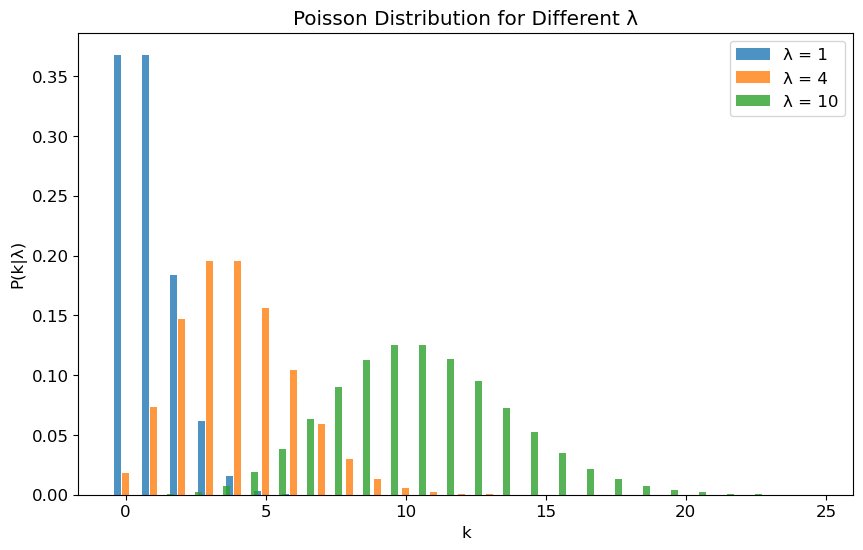

In [29]:
# Plot some Poisson distributions
fig, ax = plt.subplots(figsize=(10, 6))

for lam in [1, 4, 10]:
    k = np.arange(0, 25)
    pmf = stats.poisson.pmf(k, lam)
    ax.bar(k + 0.1*(lam-4), pmf, width=0.25, alpha=0.8, label=f'λ = {lam}')

ax.set_xlabel('k')
ax.set_ylabel('P(k|λ)')
ax.set_title('Poisson Distribution for Different λ')
ax.legend()
plt.savefig('activity2_poisson.png', dpi=150)
plt.show()

---
# Activity 3: Multi-dimensional Gaussian Distributions

## Theory

A 2D Gaussian PDF with mean $\boldsymbol{\mu}$ and covariance matrix $\boldsymbol{\Sigma}$ is:

$$p(\mathbf{x}) = \frac{1}{2\pi|\boldsymbol{\Sigma}|^{1/2}} \exp\left(-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^T \boldsymbol{\Sigma}^{-1} (\mathbf{x}-\boldsymbol{\mu})\right)$$

For our case:
$$\boldsymbol{\mu} = \begin{pmatrix} 0 \\ 0 \end{pmatrix}, \quad \boldsymbol{\Sigma} = \begin{pmatrix} 4 & 2 \\ 2 & 16 \end{pmatrix}$$

The diagonal elements give the variances: $\sigma_x^2 = 4$ and $\sigma_y^2 = 16$.

The off-diagonal element (covariance) tells us the variables are **positively correlated**: when $x$ is above average, $y$ tends to be above average too.

The correlation coefficient is:
$$\rho = \frac{\text{Cov}(x,y)}{\sigma_x \sigma_y} = \frac{2}{\sqrt{4}\sqrt{16}} = \frac{2}{2 \cdot 4} = 0.25$$

In [30]:
# Generate 1000 samples from 2D Gaussian
mean = np.array([0, 0])
cov = np.array([[4, 2], 
                [2, 16]])

samples = np.random.multivariate_normal(mean, cov, size=1000)
x_samples = samples[:, 0]
y_samples = samples[:, 1]

print("Sample statistics:")
print(f"Mean x: {np.mean(x_samples):.3f} (expected: 0)")
print(f"Mean y: {np.mean(y_samples):.3f} (expected: 0)")
print(f"Var x:  {np.var(x_samples):.3f} (expected: 4)")
print(f"Var y:  {np.var(y_samples):.3f} (expected: 16)")
print(f"Cov(x,y): {np.cov(x_samples, y_samples)[0,1]:.3f} (expected: 2)")

Sample statistics:
Mean x: -0.015 (expected: 0)
Mean y: 0.053 (expected: 0)
Var x:  3.776 (expected: 4)
Var y:  15.369 (expected: 16)
Cov(x,y): 1.742 (expected: 2)


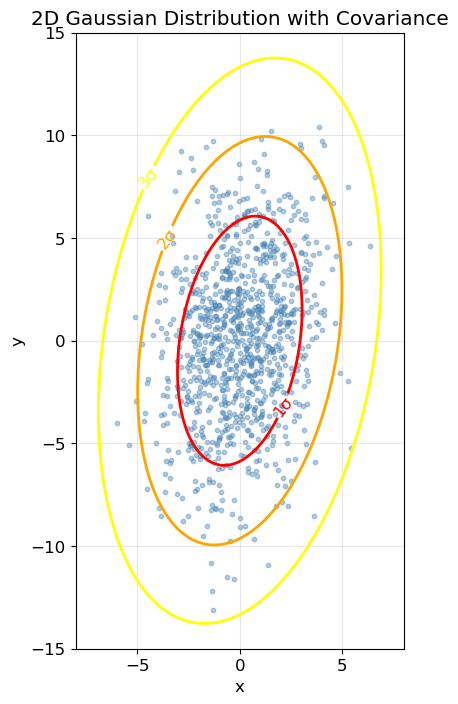

In [31]:
# Scatter plot with contours
fig, ax = plt.subplots(figsize=(8, 8))

# scatter plot
ax.scatter(x_samples, y_samples, alpha=0.4, s=10, c='steelblue')

# contours of constant probability density
# for a 2D Gaussian, contours are ellipses where (x-μ)^T Σ^(-1) (x-μ) = const
x_grid = np.linspace(-8, 8, 100)
y_grid = np.linspace(-15, 15, 100)
X, Y = np.meshgrid(x_grid, y_grid)
pos = np.dstack((X, Y))

rv = stats.multivariate_normal(mean, cov)
Z = rv.pdf(pos)

# contour levels at 1σ, 2σ, 3σ (containing ~39%, 86%, 99% of probability)
# for 2D Gaussian, these correspond to Δχ² = 2.30, 6.18, 11.83
levels = rv.pdf(mean) * np.exp(-np.array([5.92, 3.09, 1.15]))  # 3σ, 2σ, 1σ (must be increasing)
contours = ax.contour(X, Y, Z, levels=levels, colors=['yellow', 'orange', 'red'], linewidths=2)
ax.clabel(contours, fmt={levels[0]: '3σ', levels[1]: '2σ', levels[2]: '1σ'})

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('2D Gaussian Distribution with Covariance')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

plt.savefig('activity3_2dgaussian.png', dpi=150)
plt.show()

---
# Activity 4: Maximum Likelihood Estimation for a Gaussian

## Setup

We have $N$ data points $\{x_n\}_{n=1}^{N}$ drawn i.i.d. from $\mathcal{N}(\mu, \sigma^2)$.

## 1. Likelihood Function

Since the samples are independent:

$$p(\{x_n\} | \mu, \sigma^2) = \prod_{n=1}^{N} p(x_n | \mu, \sigma^2) = \prod_{n=1}^{N} \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x_n - \mu)^2}{2\sigma^2}\right)$$

$$= \frac{1}{(2\pi\sigma^2)^{N/2}} \exp\left(-\frac{1}{2\sigma^2}\sum_{n=1}^{N}(x_n - \mu)^2\right)$$

## 2. Log-Likelihood

Taking the log (easier to work with):

$$\ln L = -\frac{N}{2}\ln(2\pi) - \frac{N}{2}\ln(\sigma^2) - \frac{1}{2\sigma^2}\sum_{n=1}^{N}(x_n - \mu)^2$$

## 3. MLE for μ

Take derivative w.r.t. $\mu$ and set to zero:

$$\frac{\partial \ln L}{\partial \mu} = \frac{1}{\sigma^2}\sum_{n=1}^{N}(x_n - \mu) = 0$$

$$\sum_{n=1}^{N} x_n - N\mu = 0$$

$$\boxed{\mu_{ML} = \frac{1}{N}\sum_{n=1}^{N} x_n = \bar{x}}$$

The MLE for the mean is just the sample mean. Makes sense!

## 4. MLE for σ²

Take derivative w.r.t. $\sigma^2$ and set to zero:

$$\frac{\partial \ln L}{\partial \sigma^2} = -\frac{N}{2\sigma^2} + \frac{1}{2(\sigma^2)^2}\sum_{n=1}^{N}(x_n - \mu)^2 = 0$$

$$\frac{N}{2\sigma^2} = \frac{1}{2(\sigma^2)^2}\sum_{n=1}^{N}(x_n - \mu)^2$$

$$\boxed{\sigma^2_{ML} = \frac{1}{N}\sum_{n=1}^{N}(x_n - \mu_{ML})^2}$$

In [32]:
# Demonstrate the bias numerically
true_mu = 5.0
true_sigma = 2.0

print("Demonstrating bias in MLE variance estimator:")
print("-" * 60)
print(f"True σ² = {true_sigma**2}")
print(f"{'N':>6} {'<σ²_ML>':>12} {'<s²>':>12} {'(N-1)/N':>12}")
print("-" * 60)

for N in [5, 10, 50, 100, 1000]:
    n_trials = 10000
    var_ML_samples = []
    var_unbiased_samples = []
    
    for _ in range(n_trials):
        data = np.random.normal(true_mu, true_sigma, size=N)
        xbar = np.mean(data)
        var_ML = np.sum((data - xbar)**2) / N  # biased
        var_unbiased = np.sum((data - xbar)**2) / (N-1)  # unbiased
        var_ML_samples.append(var_ML)
        var_unbiased_samples.append(var_unbiased)
    
    print(f"{N:>6} {np.mean(var_ML_samples):>12.3f} {np.mean(var_unbiased_samples):>12.3f} {(N-1)/N:>12.3f}")

Demonstrating bias in MLE variance estimator:
------------------------------------------------------------
True σ² = 4.0
     N      <σ²_ML>         <s²>      (N-1)/N
------------------------------------------------------------
     5        3.160        3.951        0.800
    10        3.609        4.010        0.900
    50        3.922        4.002        0.980
   100        3.958        3.998        0.990
  1000        3.998        4.002        0.999


---
# Activity 5: MLE for Multivariate Gaussian + Sequential Estimator

## Theory

For a multivariate Gaussian with $D$-dimensional observations $\{\mathbf{x}_n\}_{n=1}^{N}$, the MLE estimators are:

$$\boldsymbol{\mu}_{ML} = \frac{1}{N}\sum_{n=1}^{N}\mathbf{x}_n$$

$$\boldsymbol{\Sigma}_{ML} = \frac{1}{N}\sum_{n=1}^{N}(\mathbf{x}_n - \boldsymbol{\mu}_{ML})(\mathbf{x}_n - \boldsymbol{\mu}_{ML})^T$$

Just like the 1D case, $\boldsymbol{\Sigma}_{ML}$ is biased. The unbiased estimator uses $N-1$ instead of $N$.

## Sequential Estimator (Section 2.3.5 in Bishop)

For the mean, we can update our estimate as each new data point arrives:

$$\boldsymbol{\mu}_{ML}^{(N)} = \boldsymbol{\mu}_{ML}^{(N-1)} + \frac{1}{N}(\mathbf{x}_N - \boldsymbol{\mu}_{ML}^{(N-1)})$$

This is really useful when you have streaming data or when you can't store all the data points in memory.

In [41]:
# Generate 2D Gaussian data
true_mean = np.array([3.0, -2.0])
true_cov = np.array([[2.0, 0.5],
                     [0.5, 1.0]])

N = 500
data = np.random.multivariate_normal(true_mean, true_cov, size=N)

# Standard (batch) MLE
mu_ML = np.mean(data, axis=0)
Sigma_ML = np.cov(data.T, bias=True)  # bias=True gives 1/N (ML estimator)
Sigma_unbiased = np.cov(data.T, bias=False)  # default is 1/(N-1)

print("=== Batch MLE Results ===")
print(f"\nTrue mean: {true_mean}")
print(f"MLE mean:  {mu_ML}")
print(f"\nTrue covariance:\n{true_cov}")
print(f"\nMLE covariance (biased):\n{Sigma_ML}")
print(f"\nUnbiased covariance:\n{Sigma_unbiased}")

=== Batch MLE Results ===

True mean: [ 3. -2.]
MLE mean:  [ 3.00650833 -2.01940946]

True covariance:
[[2.  0.5]
 [0.5 1. ]]

MLE covariance (biased):
[[1.99469051 0.65206627]
 [0.65206627 1.08317883]]

Unbiased covariance:
[[1.99868789 0.65337302]
 [0.65337302 1.08534953]]


In [42]:
# Sequential estimator for mean
def sequential_mean_estimator(data):
    """Update mean estimate as each point arrives."""
    N = len(data)
    D = data.shape[1]
    
    mu_history = np.zeros((N, D))
    mu = data[0].copy()  # initialize with first point
    mu_history[0] = mu
    
    for n in range(1, N):
        mu = mu + (data[n] - mu) / (n + 1)
        mu_history[n] = mu
    
    return mu_history

mu_history = sequential_mean_estimator(data)

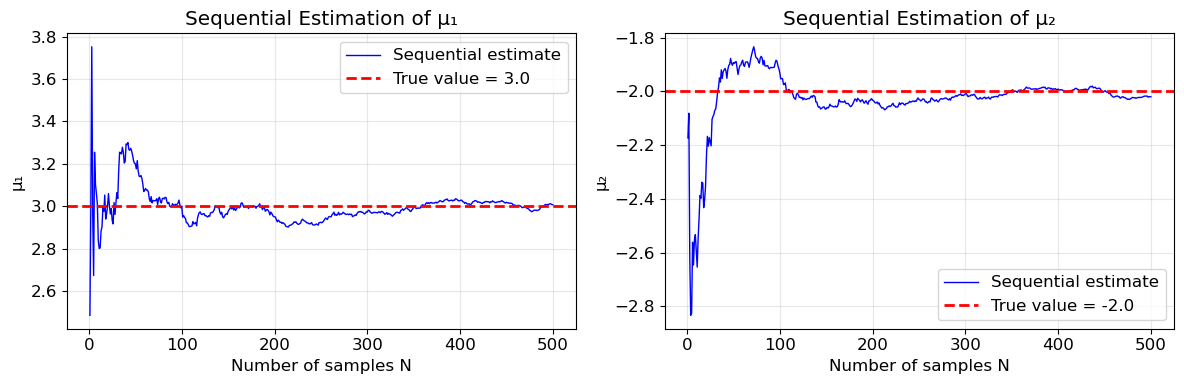


Final sequential estimate: [ 3.00650833 -2.01940946]
Batch MLE estimate:        [ 3.00650833 -2.01940946]
(These should match!)


In [43]:
# Plot convergence
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

n_vals = np.arange(1, N+1)

for i, (ax, label) in enumerate(zip(axes, ['μ₁', 'μ₂'])):
    ax.plot(n_vals, mu_history[:, i], 'b-', lw=1, label='Sequential estimate')
    ax.axhline(true_mean[i], color='r', ls='--', lw=2, label=f'True value = {true_mean[i]}')
    ax.set_xlabel('Number of samples N')
    ax.set_ylabel(label)
    ax.set_title(f'Sequential Estimation of {label}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('activity5_sequential.png', dpi=150)
plt.show()

print(f"\nFinal sequential estimate: {mu_history[-1]}")
print(f"Batch MLE estimate:        {mu_ML}")
print("(These should match!)")

## Discussion: Bias in Estimators

An estimator $\hat{\theta}$ is **biased** if $\langle \hat{\theta} \rangle \neq \theta_{true}$.

For the MLE covariance estimator:
$$\langle \boldsymbol{\Sigma}_{ML} \rangle = \frac{N-1}{N}\boldsymbol{\Sigma}_{true}$$

**Remedies:**
1. **Bessel's correction**: Multiply by $N/(N-1)$, which gives the unbiased estimator.
2. **Bayesian approach**: Instead of point estimates, compute the full posterior distribution. The posterior mean can be designed to be unbiased.
3. **Just use large N**: For large samples, the bias becomes negligible.

---
# Activity 6: Likelihood Shape and Parameter Uncertainty

The width of the likelihood function tells us about parameter uncertainty. Narrower peak = more certain about the parameter.

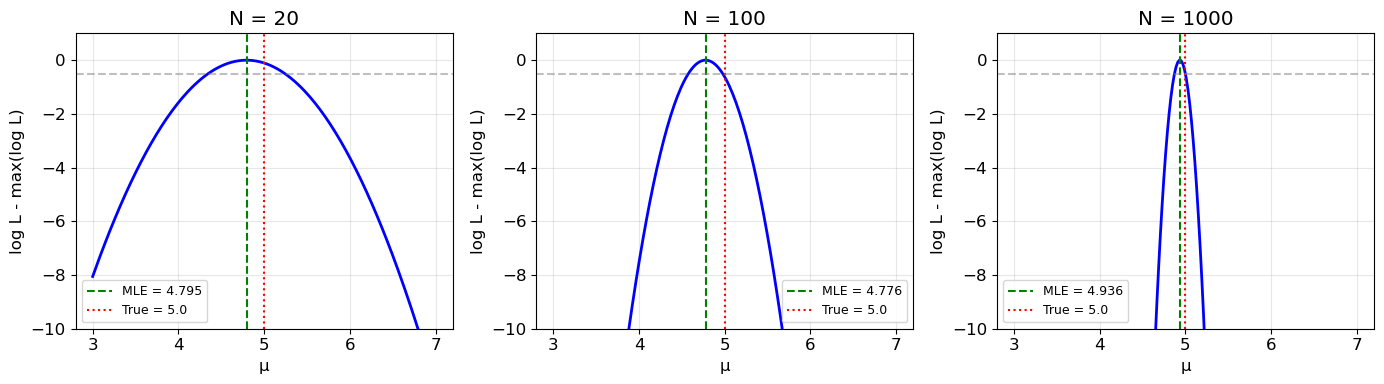

In [35]:
# True parameters
true_mu = 5.0
true_sigma = 2.0

def log_likelihood(mu_trial, data, sigma):
    """Compute log-likelihood for given mu (assuming sigma known)."""
    N = len(data)
    return -N/2 * np.log(2*np.pi*sigma**2) - np.sum((data - mu_trial)**2) / (2*sigma**2)

# Generate samples for different N
sample_sizes = [20, 100, 1000]
mu_grid = np.linspace(3, 7, 200)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, N in zip(axes, sample_sizes):
    data = np.random.normal(true_mu, true_sigma, size=N)
    
    # compute log-likelihood over grid
    ll_values = [log_likelihood(mu, data, true_sigma) for mu in mu_grid]
    ll_values = np.array(ll_values)
    
    # normalize for plotting (shift so max is 0)
    ll_values = ll_values - np.max(ll_values)
    
    ax.plot(mu_grid, ll_values, 'b-', lw=2)
    
    # find MLE
    mu_MLE = np.mean(data)
    ax.axvline(mu_MLE, color='green', ls='--', label=f'MLE = {mu_MLE:.3f}')
    ax.axvline(true_mu, color='red', ls=':', label=f'True = {true_mu}')
    
    # mark -0.5 level (1σ interval for Gaussian likelihood)
    ax.axhline(-0.5, color='gray', ls='--', alpha=0.5)
    
    ax.set_xlabel('μ')
    ax.set_ylabel('log L - max(log L)')
    ax.set_title(f'N = {N}')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-10, 1)

plt.tight_layout()
plt.savefig('activity6_likelihood.png', dpi=150)
plt.show()

In [15]:
# Quantify the width of the likelihood peak
print("Uncertainty in μ as function of N:")
print("-" * 50)
print(f"{'N':>6} {'σ_μ (theory)':>15} {'σ_μ (from fit)':>18}")
print("-" * 50)

for N in [20, 100, 1000]:
    # Theory: σ_μ = σ/√N
    sigma_mu_theory = true_sigma / np.sqrt(N)
    
    # From repeated experiments
    mu_estimates = [np.mean(np.random.normal(true_mu, true_sigma, N)) for _ in range(10000)]
    sigma_mu_empirical = np.std(mu_estimates)
    
    print(f"{N:>6} {sigma_mu_theory:>15.4f} {sigma_mu_empirical:>18.4f}")

print("\nThe uncertainty scales as 1/√N, as expected!")

Uncertainty in μ as function of N:
--------------------------------------------------
     N    σ_μ (theory)     σ_μ (from fit)
--------------------------------------------------
    20          0.4472             0.4438
   100          0.2000             0.2009
  1000          0.0632             0.0630

The uncertainty scales as 1/√N, as expected!


## Discussion

The key observations:

1. **The likelihood peak gets narrower as N increases.** With more data, we're more certain about the parameter.

2. **The width scales as $1/\sqrt{N}$.** This is because the uncertainty in the mean is $\sigma_{\bar{x}} = \sigma/\sqrt{N}$.

3. **The log-likelihood is a parabola** (for Gaussian data). This makes sense because $\ln L \propto -\sum(x_n - \mu)^2$, which is quadratic in $\mu$.

4. **The -0.5 level gives the 1σ interval.** For a Gaussian likelihood, $\Delta \ln L = -0.5$ corresponds to 1 standard deviation uncertainty (68% confidence interval).

---
# Activity 7: Bayesian Inference for Gaussian Parameters

## Part 1: Known σ², infer μ

Following Bishop Section 2.3.6, if we have a Gaussian prior on $\mu$:

$$p(\mu) = \mathcal{N}(\mu | \mu_0, \sigma_0^2)$$

And data likelihood:

$$p(\{x_n\} | \mu) = \prod_{n=1}^{N} \mathcal{N}(x_n | \mu, \sigma^2)$$

The posterior is also Gaussian (Gaussian is **conjugate prior** for Gaussian likelihood):

$$p(\mu | \{x_n\}) = \mathcal{N}(\mu | \mu_N, \sigma_N^2)$$

where:

$$\mu_N = \frac{\sigma^2}{N\sigma_0^2 + \sigma^2}\mu_0 + \frac{N\sigma_0^2}{N\sigma_0^2 + \sigma^2}\bar{x}$$

$$\frac{1}{\sigma_N^2} = \frac{1}{\sigma_0^2} + \frac{N}{\sigma^2}$$

The posterior mean is a **weighted average** of the prior mean and the sample mean, with weights proportional to their precisions.

In [45]:
# Setup
true_mu = 5.0
known_sigma = 2.0  # assume we know this

# Prior parameters
mu_0 = 0.0  # prior mean
sigma_0 = 3.0  # prior std

# Generate data
np.random.seed(42)
all_data = np.random.normal(true_mu, known_sigma, size=100)

def bayesian_update_mu(data, mu_0, sigma_0, sigma):
    """Compute posterior parameters for mu given data."""
    N = len(data)
    xbar = np.mean(data)
    
    # Posterior variance
    sigma_N_sq = 1 / (1/sigma_0**2 + N/sigma**2)
    sigma_N = np.sqrt(sigma_N_sq)
    
    # Posterior mean
    mu_N = sigma_N_sq * (mu_0/sigma_0**2 + N*xbar/sigma**2)
    
    return mu_N, sigma_N

# Track posterior evolution
N_values = [1, 5, 10, 20, 50, 100,200]
results = []

for N in N_values:
    data = all_data[:N]
    mu_N, sigma_N = bayesian_update_mu(data, mu_0, sigma_0, known_sigma)
    mu_ML = np.mean(data)
    results.append({'N': N, 'mu_N': mu_N, 'sigma_N': sigma_N, 'mu_ML': mu_ML})

print("Bayesian vs MLE for μ (known σ²):")
print("-" * 60)
print(f"{'N':>6} {'μ_posterior':>12} {'σ_posterior':>14} {'μ_ML':>10}")
print("-" * 60)
for r in results:
    print(f"{r['N']:>6} {r['mu_N']:>12.4f} {r['sigma_N']:>14.4f} {r['mu_ML']:>10.4f}")
print(f"\nTrue μ = {true_mu}")

Bayesian vs MLE for μ (known σ²):
------------------------------------------------------------
     N  μ_posterior    σ_posterior       μ_ML
------------------------------------------------------------
     1       4.1493         1.6641     5.9934
     5       5.4349         0.8571     5.9180
    10       5.6452         0.6189     5.8961
    20       4.5562         0.4423     4.6574
    50       4.5090         0.2816     4.5491
   100       4.7711         0.1996     4.7923
   200       4.7711         0.1996     4.7923

True μ = 5.0


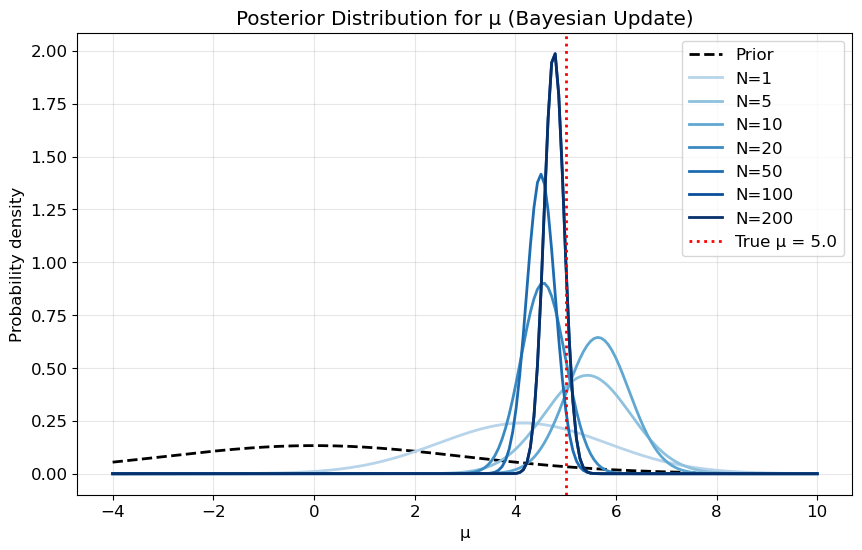

In [46]:
# Visualize posterior evolution
fig, ax = plt.subplots(figsize=(10, 6))

mu_grid = np.linspace(-4, 10, 200)

# Prior
prior = stats.norm.pdf(mu_grid, mu_0, sigma_0)
ax.plot(mu_grid, prior, 'k--', lw=2, label='Prior')

colors = plt.cm.Blues(np.linspace(0.3, 1, len(N_values)))

for r, c in zip(results, colors):
    posterior = stats.norm.pdf(mu_grid, r['mu_N'], r['sigma_N'])
    ax.plot(mu_grid, posterior, color=c, lw=2, label=f"N={r['N']}")

ax.axvline(true_mu, color='red', ls=':', lw=2, label=f'True μ = {true_mu}')

ax.set_xlabel('μ')
ax.set_ylabel('Probability density')
ax.set_title('Posterior Distribution for μ (Bayesian Update)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.savefig('activity7_bayesian_mu.png', dpi=150)
plt.show()

## Part 2: Known μ, infer σ²

Following Bishop pages 97-99, we use a **Gamma distribution** as the conjugate prior for the precision $\lambda = 1/\sigma^2$:

$$p(\lambda) = \text{Gam}(\lambda | a_0, b_0) = \frac{b_0^{a_0}}{\Gamma(a_0)}\lambda^{a_0-1}e^{-b_0\lambda}$$

The posterior is also Gamma with:

$$a_N = a_0 + \frac{N}{2}$$

$$b_N = b_0 + \frac{1}{2}\sum_{n=1}^{N}(x_n - \mu)^2$$

In [18]:
# Setup
known_mu = 5.0
true_sigma = 2.0
true_precision = 1/true_sigma**2  # = 0.25

# Prior parameters for Gamma(a, b)
# Mean of Gamma is a/b, variance is a/b^2
# Let's set a weakly informative prior
a_0 = 1.0
b_0 = 1.0

def bayesian_update_precision(data, mu, a_0, b_0):
    """Compute posterior Gamma parameters for precision."""
    N = len(data)
    a_N = a_0 + N/2
    b_N = b_0 + 0.5 * np.sum((data - mu)**2)
    return a_N, b_N

# Track posterior evolution
N_values = [5, 10, 20, 50, 100]
results_precision = []

for N in N_values:
    data = all_data[:N]
    a_N, b_N = bayesian_update_precision(data, known_mu, a_0, b_0)
    
    # Posterior mean and std for precision
    lambda_mean = a_N / b_N
    lambda_std = np.sqrt(a_N) / b_N
    
    # MLE for variance
    var_ML = np.sum((data - known_mu)**2) / N
    precision_ML = 1/var_ML
    
    results_precision.append({
        'N': N, 'a_N': a_N, 'b_N': b_N,
        'lambda_mean': lambda_mean, 'lambda_std': lambda_std,
        'precision_ML': precision_ML
    })

print(f"Bayesian inference for precision λ = 1/σ² (true λ = {true_precision:.4f}):")
print("-" * 70)
print(f"{'N':>6} {'<λ>_post':>12} {'σ_λ':>10} {'λ_ML':>10}")
print("-" * 70)
for r in results_precision:
    print(f"{r['N']:>6} {r['lambda_mean']:>12.4f} {r['lambda_std']:>10.4f} {r['precision_ML']:>10.4f}")

Bayesian inference for precision λ = 1/σ² (true λ = 0.2500):
----------------------------------------------------------------------
     N     <λ>_post        σ_λ       λ_ML
----------------------------------------------------------------------
     5       0.4916     0.2628     0.4085
    10       0.4160     0.1698     0.3725
    20       0.2957     0.0892     0.2763
    50       0.2841     0.0557     0.2762
   100       0.3064     0.0429     0.3022


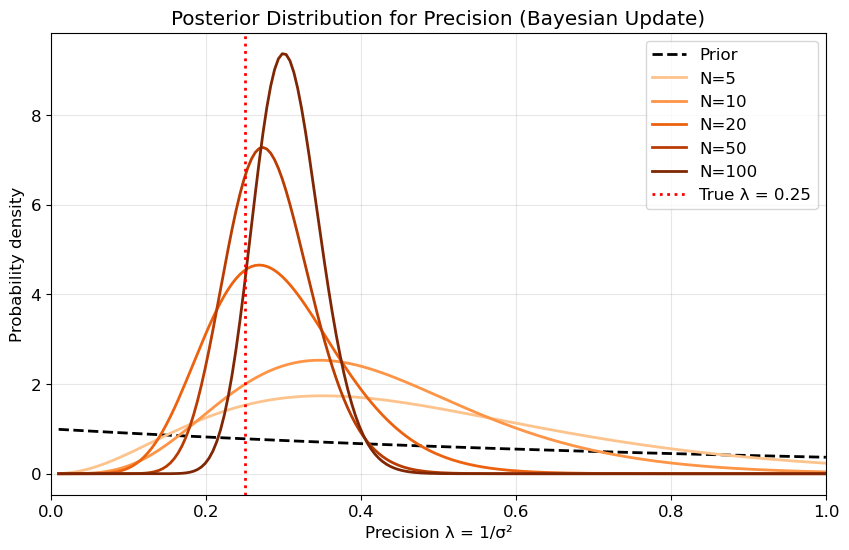

In [19]:
# Visualize posterior for precision
fig, ax = plt.subplots(figsize=(10, 6))

lambda_grid = np.linspace(0.01, 1.0, 200)

# Prior
prior = stats.gamma.pdf(lambda_grid, a=a_0, scale=1/b_0)
ax.plot(lambda_grid, prior, 'k--', lw=2, label='Prior')

colors = plt.cm.Oranges(np.linspace(0.3, 1, len(results_precision)))

for r, c in zip(results_precision, colors):
    posterior = stats.gamma.pdf(lambda_grid, a=r['a_N'], scale=1/r['b_N'])
    ax.plot(lambda_grid, posterior, color=c, lw=2, label=f"N={r['N']}")

ax.axvline(true_precision, color='red', ls=':', lw=2, label=f'True λ = {true_precision}')

ax.set_xlabel('Precision λ = 1/σ²')
ax.set_ylabel('Probability density')
ax.set_title('Posterior Distribution for Precision (Bayesian Update)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1)

plt.savefig('activity7_bayesian_precision.png', dpi=150)
plt.show()

## Discussion: Conjugate Priors

A **conjugate prior** is one where the posterior has the same functional form as the prior. This is super convenient because:

1. **Analytical solutions**: We can compute the posterior exactly, no numerical integration needed.

2. **Iterative updates**: Since posterior has the same form as prior, we can use today's posterior as tomorrow's prior. This lets us do sequential/online Bayesian inference.

3. **Interpretable parameters**: The prior parameters often have nice interpretations as "pseudo-observations."

---
# Activity 8: Prior Sensitivity in Bayesian Mean Inference

Let's see how the choice of prior affects our inference, and how that influence changes with sample size.

In [20]:
# True parameters
true_mu = 5.0
known_sigma = 2.0

# Two priors: narrow and broad, both centered away from truth
narrow_prior = {'mu_0': 0.0, 'sigma_0': 0.5}  # very confident but wrong
broad_prior = {'mu_0': 0.0, 'sigma_0': 10.0}  # not confident

# Generate data
np.random.seed(123)
all_data = np.random.normal(true_mu, known_sigma, size=200)

def compare_priors(data, narrow, broad, sigma):
    """Compare posterior for narrow vs broad prior."""
    mu_narrow, sigma_narrow = bayesian_update_mu(data, narrow['mu_0'], narrow['sigma_0'], sigma)
    mu_broad, sigma_broad = bayesian_update_mu(data, broad['mu_0'], broad['sigma_0'], sigma)
    return {
        'narrow': {'mu': mu_narrow, 'sigma': sigma_narrow},
        'broad': {'mu': mu_broad, 'sigma': sigma_broad}
    }

# Compare for different N
N_values = [5, 20, 100, 200]

print("Prior sensitivity comparison:")
print("=" * 70)
print(f"Narrow prior: μ₀ = {narrow_prior['mu_0']}, σ₀ = {narrow_prior['sigma_0']}")
print(f"Broad prior:  μ₀ = {broad_prior['mu_0']}, σ₀ = {broad_prior['sigma_0']}")
print(f"True μ = {true_mu}")
print("=" * 70)
print(f"\n{'N':>6} {'μ_narrow':>12} {'σ_narrow':>10} {'μ_broad':>12} {'σ_broad':>10}")
print("-" * 55)

results_comparison = []
for N in N_values:
    data = all_data[:N]
    result = compare_priors(data, narrow_prior, broad_prior, known_sigma)
    result['N'] = N
    result['xbar'] = np.mean(data)
    results_comparison.append(result)
    
    print(f"{N:>6} {result['narrow']['mu']:>12.4f} {result['narrow']['sigma']:>10.4f} "
          f"{result['broad']['mu']:>12.4f} {result['broad']['sigma']:>10.4f}")

Prior sensitivity comparison:
Narrow prior: μ₀ = 0.0, σ₀ = 0.5
Broad prior:  μ₀ = 0.0, σ₀ = 10.0
True μ = 5.0

     N     μ_narrow   σ_narrow      μ_broad    σ_broad
-------------------------------------------------------
     5       1.0105     0.4364       4.2102     0.8909
    20       2.9049     0.3333       5.2184     0.4468
   100       4.3571     0.1857       5.0522     0.2000
   200       4.6366     0.1361       5.0066     0.1414


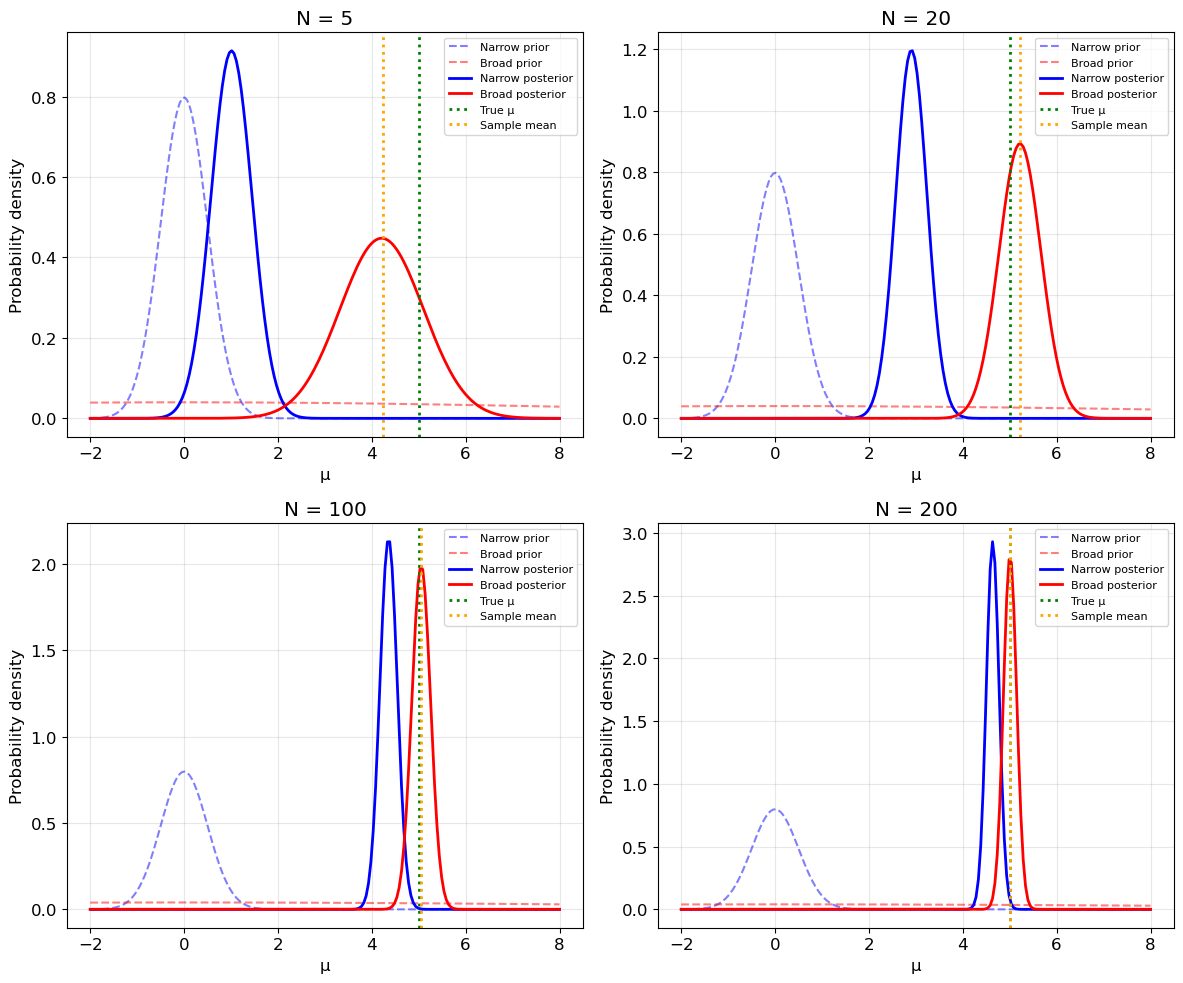

In [21]:
# Visualize
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

mu_grid = np.linspace(-2, 8, 200)

for ax, r in zip(axes, results_comparison):
    N = r['N']
    
    # Priors
    narrow_prior_pdf = stats.norm.pdf(mu_grid, narrow_prior['mu_0'], narrow_prior['sigma_0'])
    broad_prior_pdf = stats.norm.pdf(mu_grid, broad_prior['mu_0'], broad_prior['sigma_0'])
    
    # Posteriors
    narrow_post = stats.norm.pdf(mu_grid, r['narrow']['mu'], r['narrow']['sigma'])
    broad_post = stats.norm.pdf(mu_grid, r['broad']['mu'], r['broad']['sigma'])
    
    ax.plot(mu_grid, narrow_prior_pdf, 'b--', alpha=0.5, label='Narrow prior')
    ax.plot(mu_grid, broad_prior_pdf, 'r--', alpha=0.5, label='Broad prior')
    ax.plot(mu_grid, narrow_post, 'b-', lw=2, label='Narrow posterior')
    ax.plot(mu_grid, broad_post, 'r-', lw=2, label='Broad posterior')
    
    ax.axvline(true_mu, color='green', ls=':', lw=2, label=f'True μ')
    ax.axvline(r['xbar'], color='orange', ls=':', lw=2, label=f'Sample mean')
    
    ax.set_xlabel('μ')
    ax.set_ylabel('Probability density')
    ax.set_title(f'N = {N}')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('activity8_prior_sensitivity.png', dpi=150)
plt.show()

In [22]:
# Quantify prior influence
print("\nQuantifying prior influence:")
print("-" * 60)
print(f"{'N':>6} {'|μ_narrow - μ_broad|':>25} {'Rel. diff (%)':>15}")
print("-" * 60)

for r in results_comparison:
    diff = abs(r['narrow']['mu'] - r['broad']['mu'])
    rel_diff = 100 * diff / true_mu
    print(f"{r['N']:>6} {diff:>25.4f} {rel_diff:>15.2f}")


Quantifying prior influence:
------------------------------------------------------------
     N      |μ_narrow - μ_broad|   Rel. diff (%)
------------------------------------------------------------
     5                    3.1998           64.00
    20                    2.3135           46.27
   100                    0.6951           13.90
   200                    0.3699            7.40


## Discussion: How Prior Influence Changes with N

Key observations:

1. **Small N**: The prior matters a lot. The narrow (wrong) prior pulls the posterior away from the true value. The broad prior allows the data to speak more.

2. **Large N**: Both posteriors converge to the same answer (the sample mean). The data "overwhelms" the prior.

3. **The rate of convergence**: For the broad prior, the posterior quickly approaches the data. For the narrow prior, it takes more data to overcome the prior's "confidence."

Mathematically, this is because:

$$\mu_N = \frac{\sigma^2/\sigma_0^2}{N + \sigma^2/\sigma_0^2}\mu_0 + \frac{N}{N + \sigma^2/\sigma_0^2}\bar{x}$$

As $N \to \infty$, the first term (prior contribution) → 0 and the second term → $\bar{x}$.

